Learning a little more about PyMC3. 
How to think about models from a Bayesian Perspective, data visualization techniques for assessing goodness of fit.

In [1]:
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 0.5)
    data_generator = pm.Poisson("data_generator", parameter)

In [3]:
with model:
    data_plus_one = data_generator + 1

In [4]:
data_plus_one

Elemwise{add,no_inplace}.0

In [5]:
parameter.tag.test_value

array(1.3862943649291992)

In [6]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 0.5)
    p_B = pm.Uniform("P(B)", 0, 1)

In [7]:
p_A.tag.test_value

array(0.25)

In [8]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 1.3862943649291992
data_generator.tag.test_value = 1
data_plus_one.tag.test_value = 2


In [9]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)


parameter.tag.test_value = 0.5


Two types of programming variables:
    * Stochastic: even if all the parameters and components are known, the variable is still random. Examples are poisson, discrete uniform, and exponential
    * Deterministic: not random if the parameters values and components are known. If all of the component variables have values, the value of the determistic variable can be found. 

## Stochastic Variables

Initialization requires a name argument plus class specific parameters

In [10]:
with pm.Model() as model:
    stochastic_var = pm.Exponential("exponential_var", 1)
    betas = pm.Poisson("betas", 12, shape=2)

In [11]:
stochastic_var.tag.test_value

array(0.6931471824645996)

In [12]:
betas.tag.test_value

array([12, 12], dtype=int64)

## Deterministic Variables

In [13]:
with pm.Model() as determine_model:
    lambdas = pm.Exponential('lambdas', 1.0, shape = 4)
    taus = pm.DiscreteUniform('taus', 0, 12, shape = 4)
    deterministic_var = pm.Deterministic("deterministic_var", lambdas)
    new_var = lambdas + taus

In [14]:
deterministic_var.tag.test_value

array([ 0.69314718,  0.69314718,  0.69314718,  0.69314718])

In [15]:
new_var.tag.test_value

array([ 6.69314718,  6.69314718,  6.69314718,  6.69314718])

In [16]:
import numpy as np

n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
with pm.Model() as model:
    lambda_1 = pm.Exponential('lambda_1', 1.0)
    lambda_2 = pm.Exponential('lambda_2', 10) 
    tau = pm.DiscreteUniform('tau', 0, 5)
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

In [17]:
lambda_.tag.test_value

array([ 0.69314718,  0.69314718,  0.69314718,  0.06931472,  0.06931472])

In [18]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

In [19]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

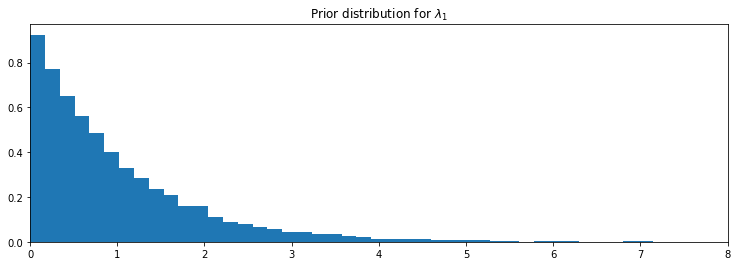

In [20]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
figsize(12.5, 4)


samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

Fix stochastic variables to an observed value.

In [21]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


In [22]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


Telling a story with distributions.

In [23]:
tau = np.random.randint(0, 80)
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)

In [24]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

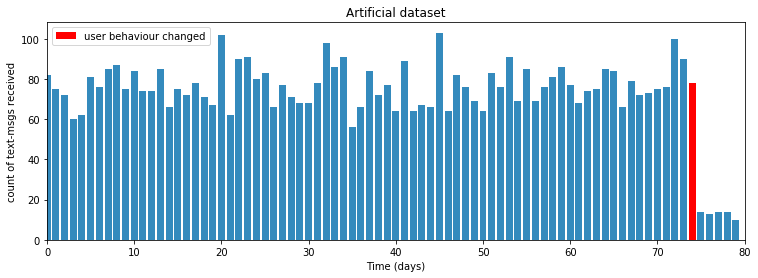

In [25]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

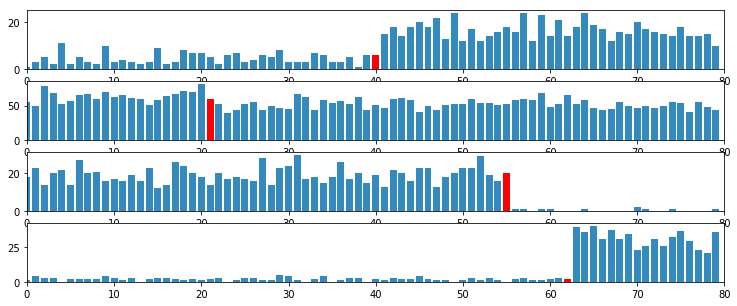

In [26]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

figsize(12.5, 5)
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

# Observed frequency differs from the true frequency

This is where Bayesian reasoning is more accurate than looking at the statistics only. We take into account the data, but also the prior estimates. We acknowledge that the measured data may not be true data.

## Example Using A/B Testing 

Know both the number of users and the buy rate. This is the observed frequency but not necessarily the true frequency.

In [27]:
import pymc3 as pm

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)
    
#set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))

[0 0 0 ..., 0 0 0]
81


In [28]:
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0540
Does this equal the true frequency? False


In [29]:
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_interval__]
The number of effective samples is smaller than 25% for some parameters.


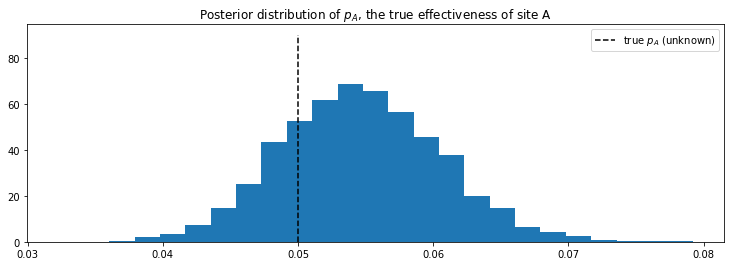

In [30]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend();

The graph represents that we are uncertain about the true conversion. We have a belief based on the data, but it does not represent the true value because of noise in observations. This shows that one trial in the real world skews the results from the true frequency.

[0 0 0 ..., 0 0 0]
485
What is the observed frequency in Group A? 0.0485
Does this equal the true frequency? False


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_interval__]
The number of effective samples is smaller than 10% for some parameters.


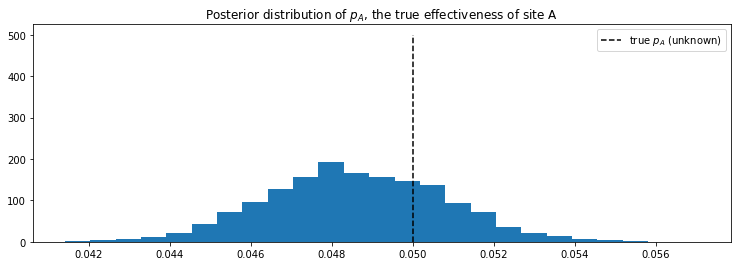

In [31]:
import pymc3 as pm

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)
    
#set constants
p_true = 0.05  # remember, this is unknown.
N = 10000

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))


print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]
    
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, N * p_true, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend();

In [32]:
import pymc3 as pm
figsize(12, 4)

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 10000
N_B = 25000

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

print(np.mean(observations_A))
print(np.mean(observations_B))

Obs from Site A:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
0.0466
0.03976


In [33]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B_interval__]
>Metropolis: [p_A_interval__]
The number of effective samples is smaller than 25% for some parameters.


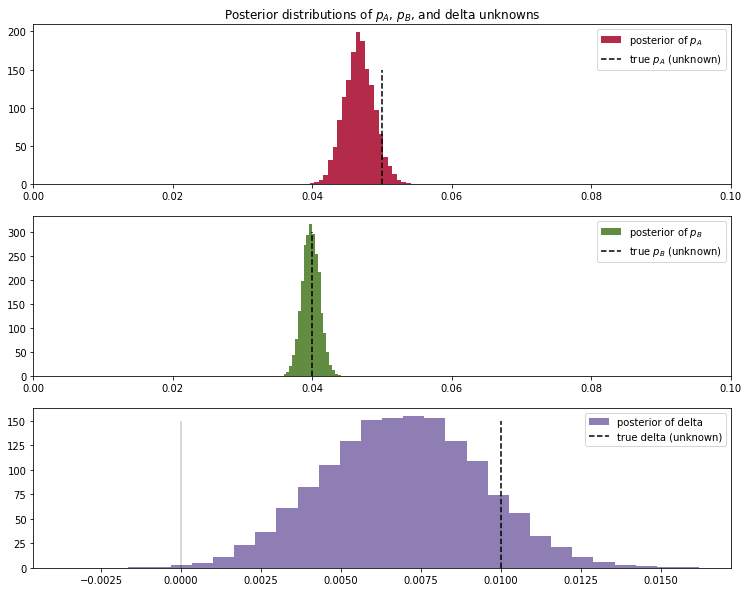

In [34]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 150, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 300, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 150, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 150, color="black", alpha=0.2)
plt.legend(loc="upper right");

# True Value is Not Equal to the Observed Value

Bayesian thinking expresses our uncertainty in the observed value. There should be a range of possible values. Each time we measure, we can expect different results because of random noise.

In [35]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.002
Probability site A is BETTER than site B: 0.998


## Binomial Distribution

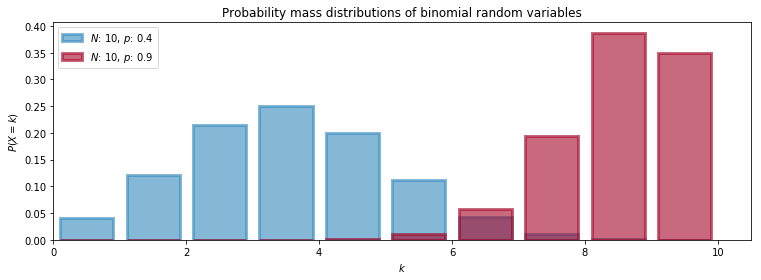

In [36]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

In [37]:
import pymc3 as pm

N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)

    true_answers = pm.Bernoulli("truths", p, shape=N, testval=np.random.binomial(1, 0.5, N))

In [38]:
with model:
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
print(first_coin_flips.tag.test_value)

[0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0
 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1
 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0]


In [39]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [40]:
import theano.tensor as tt
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [41]:
observed_proportion.tag.test_value

array(0.47999998927116394)

In [42]:
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

    step = pm.Metropolis(vars=[p])
    trace = pm.sample(1000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [freq_cheating_interval__]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
The estimated number of effective samples is smaller than 200 for some parameters.


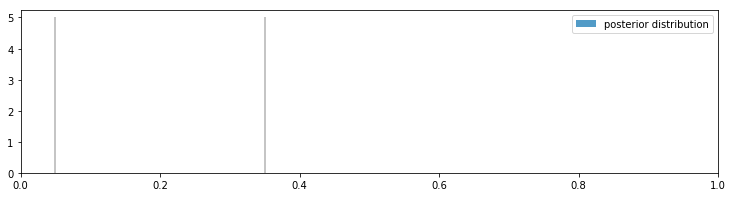

In [45]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [freq_cheating_interval__]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
The estimated number of effective samples is smaller than 200 for some parameters.


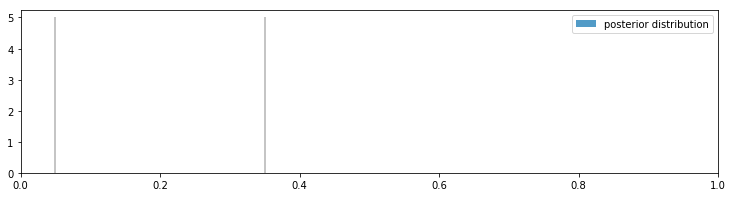

In [47]:
X = 60

with model:
    new_observations = pm.Binomial("new_obs", N, observed_proportion, observed=X)

    step = pm.Metropolis(vars=[p])
    trace = pm.sample(1000, step=step)
    burned_trace = trace[15000:]
    
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [freq_cheating_interval__]
The number of effective samples is smaller than 25% for some parameters.


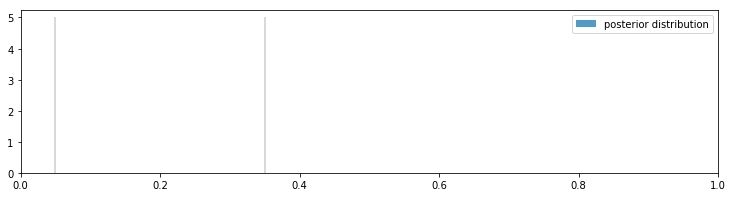

In [48]:
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=35)
    # To Be Explained in Chapter 3!
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)
    burned_trace = trace[2500:]
    
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

Arrays of variables in PyMC3

In [49]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_%i' % i, (i+1.0)**2)

# Example of Determining Posterior from Data

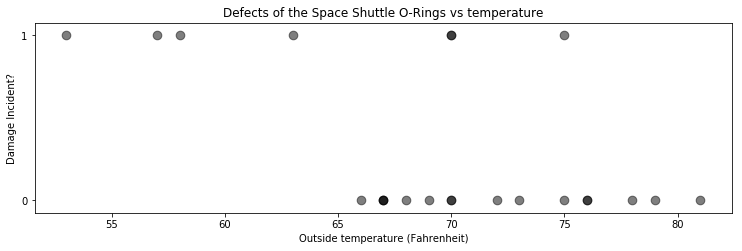

In [50]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
#print("Temp (F), O-Ring failure?")
#print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

The model of failure as a function of temperature will be a logistic function.
The objective is to determine the correct parameter of $\beta$ and the offset $\alpha$ to use in the model. This will be found from the data and finding the maximum a prior estimate. 

Here are some examples of the logistic function.

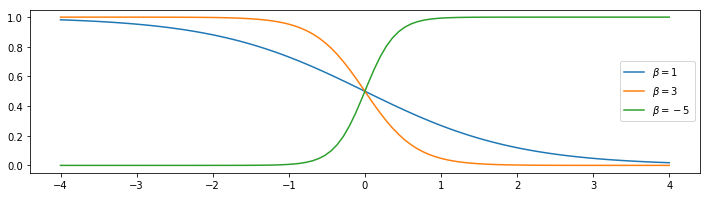

In [52]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend();

We need to add a bias term to account for the shift occurring around 60 or 70 and not 1. This will be another parameter to learn from the data.

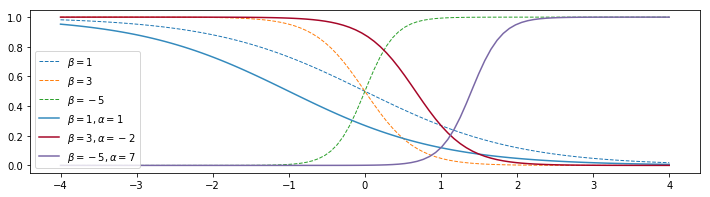

In [53]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

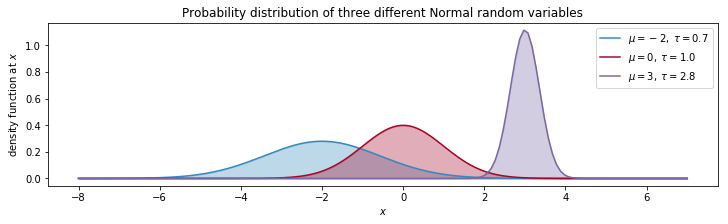

In [54]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./_tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");

We have two parameters, $\alpha$ and $\beta$ that we assume are drawn from a normal distribution. The change from an unsafe to safe temperature is modeled as a logistic function. The objective is to determine the temperature at which the change occurs. We do this by repeatedly sampling from the prior distriubtions of $\alpha$ and $\beta$ and our observations. In effect, we try to find the values of the parameters that maximize the likelihood of the data.

In [55]:
import pymc3 as pm

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))

In [56]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

logp = -19.024, ||grad|| = 9.9071: 100%|██████████| 27/27 [00:00<00:00, 690.26it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
The estimated number of effective samples is smaller than 200 for some parameters.


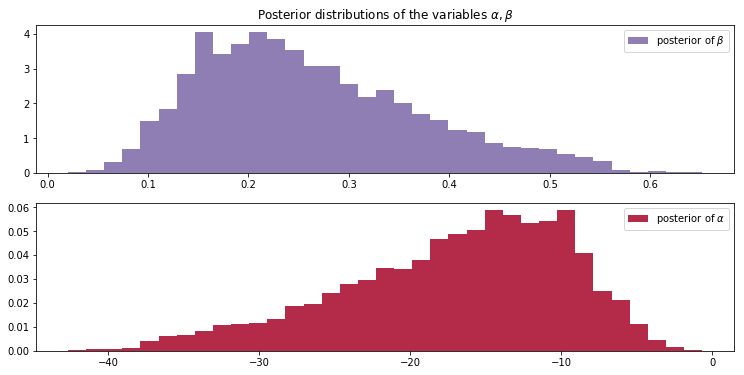

In [57]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [58]:
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

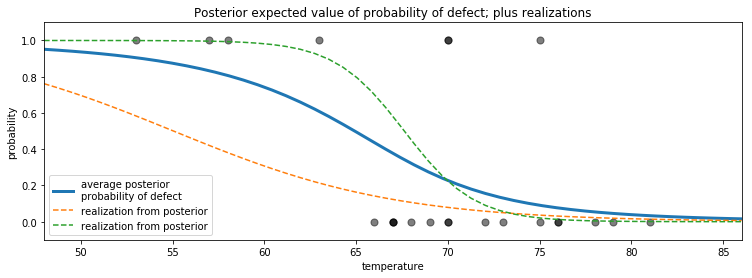

In [59]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

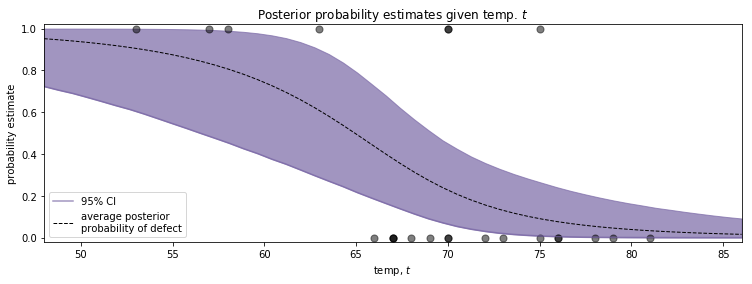

In [60]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

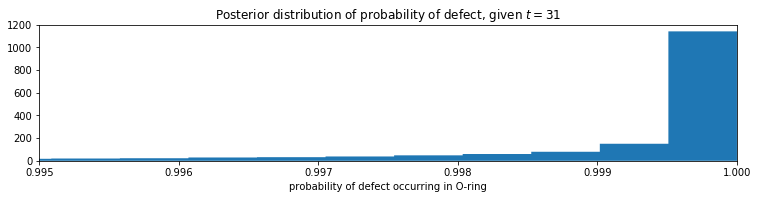

In [61]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

Create simulated data to test the model goodness of fit

The observations from data in the model are replaced with simulated data. 

In [62]:
N = 10000
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>BinaryGibbsMetropolis: [bernoulli_sim]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


(20000, 23)


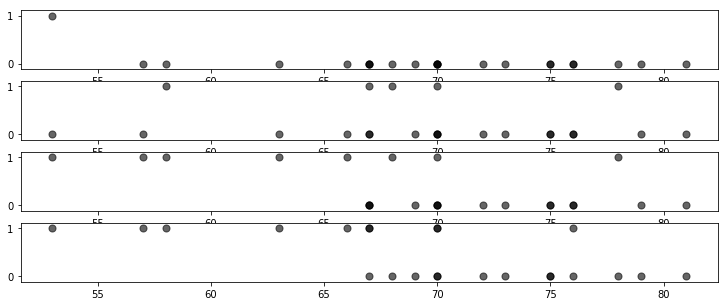

In [63]:
figsize(12.5, 5)

simulations = trace["bernoulli_sim"]
print(simulations.shape)

plt.title("Simulated dataset using posterior parameters")
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], color="k",
                s=50, alpha=0.6)

In [64]:
posterior_probability = simulations.mean(axis=0)
print("posterior prob of defect | realized defect ")
for i in range(len(D)):
    print("%.2f                     |   %d" % (posterior_probability[i], D[i]))

posterior prob of defect | realized defect 
0.42                     |   0
0.23                     |   1
0.27                     |   0
0.32                     |   0
0.37                     |   0
0.17                     |   0
0.15                     |   0
0.23                     |   0
0.77                     |   1
0.57                     |   1
0.24                     |   1
0.07                     |   0
0.37                     |   0
0.84                     |   1
0.37                     |   0
0.11                     |   0
0.24                     |   0
0.06                     |   0
0.10                     |   0
0.07                     |   0
0.11                     |   1
0.10                     |   0
0.75                     |   1


In [65]:
ix = np.argsort(posterior_probability)
print("probb | defect ")
for i in range(len(D)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], D[ix[i]]))

probb | defect 
0.06  |   0
0.07  |   0
0.07  |   0
0.10  |   0
0.10  |   0
0.11  |   1
0.11  |   0
0.15  |   0
0.17  |   0
0.23  |   0
0.23  |   1
0.24  |   0
0.24  |   1
0.27  |   0
0.32  |   0
0.37  |   0
0.37  |   0
0.37  |   0
0.42  |   0
0.57  |   1
0.75  |   1
0.77  |   1
0.84  |   1


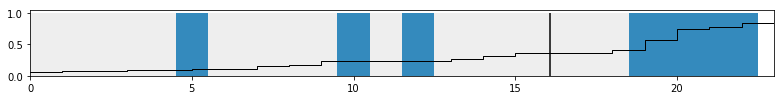

In [67]:
from separation_plot import separation_plot


figsize(11., 1.5)
separation_plot(posterior_probability, D)

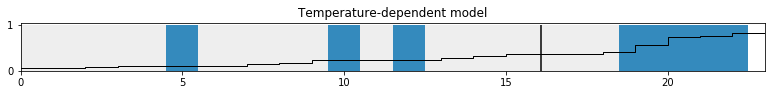

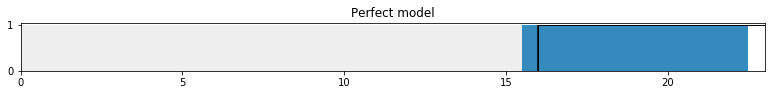

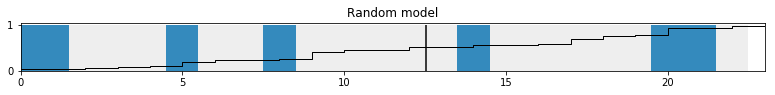

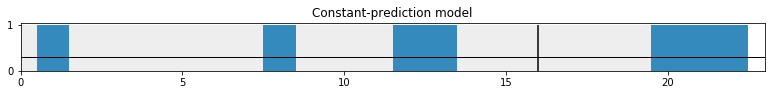

In [68]:
figsize(11., 1.25)

# Our temperature-dependent model
separation_plot(posterior_probability, D)
plt.title("Temperature-dependent model")

# Perfect model
# i.e. the probability of defect is equal to if a defect occurred or not.
p = D
separation_plot(p, D)
plt.title("Perfect model")

# random predictions
p = np.random.rand(23)
separation_plot(p, D)
plt.title("Random model")

# constant model
constant_prob = 7./23*np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model");